# Problem Statement: **CNN-Based Fashion Classification by AtliQ**

### AtliQ is launching a state-of-the-art "**Fashion Classification System**" to automatically identify clothing items and accessories from images. The goal is to build a Convolutional Neural Network (CNN) model that can classify images from the **FashionMNIST** dataset into one of its 10 categories. You'll implement an end-to-end solution using PyTorch, covering dataset preparation, CNN construction, training, evaluation, and visualization.


Imports and CUDA

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda




---



**Step1**: Dataset Overview

Load the **FashionMNIST dataset** and extract a smaller subset for training and testing.

Details:
* Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

* Use **10,000 images for training** and **3,000 images for testing** by randomly sampling from the dataset.
* Apply transformations such as random horizontal flips and random cropping for data augmentation during training.
* Normalize the pixel values to have a mean of 0 and standard deviation of 1 for faster convergence.
* Use `batch size = 64` for trainloader and testloader


Use torch.utils.data.random_split to partition the data into the desired subset sizes.

In [10]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel mean and std
])

# Load FashionMNIST dataset
dataset = torchvision.datasets.FashionMNIST(root='./data',download=True,train=True,transform=transform)

test_dataset = datasets.FashionMNIST(root='./data',download=True,train=False,transform=transform)

# Subset the dataset (use random_split)
train_subset_size, test_subset_size =(10000,3000)
train_subset, _ = random_split(dataset,[train_subset_size,len(dataset)-train_subset_size])
test_subset, _ = random_split(test_dataset,[test_subset_size,len(test_dataset)-test_subset_size])

# Create data loaders
train_loader = DataLoader(train_subset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)




---



**Step2** :Visualizing the Dataset

Let's visualize some sample images with their class labels.

Details:
* Create a 4x4 grid of 16 images from the training dataset.
* Include the class labels (e.g., 0, 1, 2, 3 etc.) under each image

Label-Image Description:
* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [11]:
classes = dataset.classes
# Retrieve a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])




---



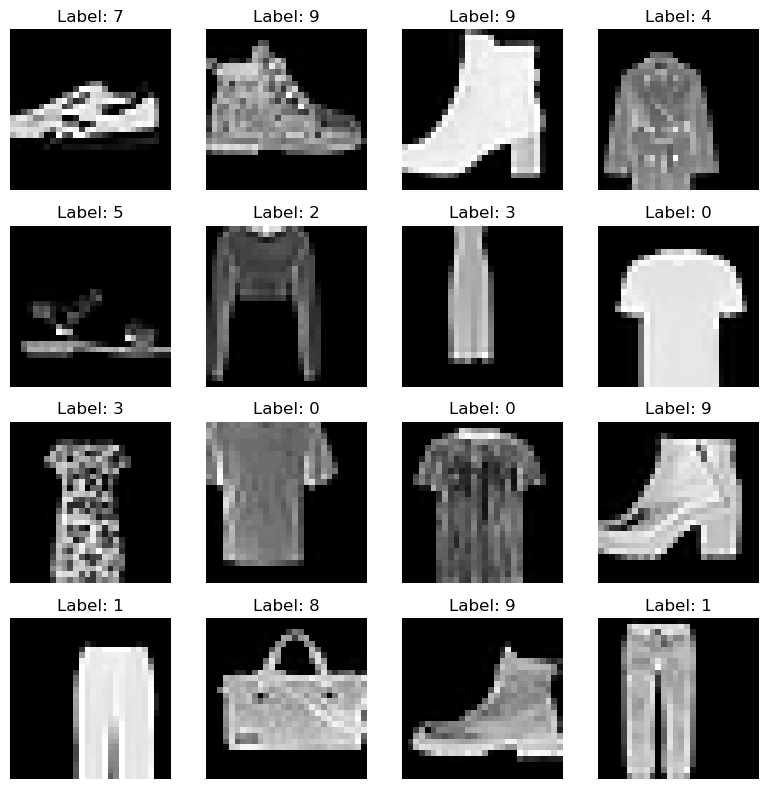

In [12]:
# Visualize a 4x4 grid of 16 images from the DataLoader
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0].numpy(), cmap='gray')  # Display image
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()




---



**Step3**: Constructing the CNN Model

Let's build a convolutional neural network to classify FashionMNIST images.

**Details:**

* Use two convolutional layers followed by pooling, activation functions (ReLU), and fully connected layers.

**CNN components:**
* Convolutions: To extract spatial features from images.
* Pooling: To reduce dimensionality while retaining important information.
* Padding: To maintain image dimensions after convolutions.
* Strides: To control the movement of the kernel over the image.

**Architecture:**

* Conv1: Input channels = 1, Output channels = 32, Kernel size = 3x3, Activation = ReLU.
* Conv2: Input channels = 32, Output channels = 64, Kernel size = 3x3, Activation = ReLU.
* MaxPooling: Kernel size = 2x2, Stride = 2.

Fully Connected Layers:
* Input = 64*7*7, Output = 128, Activation = ReLU, Dropout = 0.5.
* Output = 10 (number of classes).

In [13]:
class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        self.features = nn.Sequential(
            # Conv block 1
            nn.Conv2d(1,32,kernel_size=3,padding=1),

            # ReLU
            nn.ReLU(),

            # MaxPool
            nn.MaxPool2d(kernel_size=2,stride=2),
            # Conv block 2
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            # ReLU
            nn.ReLU(),
            # MaxPool
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        # Flatten Layer
        self.flatten=nn.Flatten()

        # Fully Connected Layers (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # 64 channels, 7x7 feature map size after pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128, 10),  # 10 output classes (for FashionMNIST)
            nn.LogSoftmax(dim=1)  # LogSoftmax for probabilistic output
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Initialize the Model
model = FashionMNISTCNN().to(device)

# Print the model architecture
print(model)

FashionMNISTCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)




---



**Step 5**: Defining Loss Function and Optimizer

Now we'll establish the optimization and evaluation criteria for training.

**Details:**

* Use Cross-Entropy Loss for multi-class classification.
* Choose Adam optimizer for faster convergence and adaptive learning rates.

Mention the learning rate and other hyperparameters:
* Learning rate = 0.001
* betas for Adam = (0.9, 0.99)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01,betas=(0.9,0.99
                                                         ))




---



**Step6**: Training the CNN Model

We will train the model on the training subset for multiple epochs.

**Details:**

* Train for **10 epochs**, where each epoch involves multiple iterations over the training subset.

Quick Revision:

* Forward pass: The model predicts outputs based on input images.
* Loss calculation: Compare predictions with true labels using the loss function.
* Backward pass: Calculate gradients using backpropagation.
* Optimizer step: Update model weights using the optimizer.
* Track the loss for each epoch to monitor convergence.

In [16]:
num_epochs =10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 2.3377
Epoch 2/10, Loss: 2.3035
Epoch 3/10, Loss: 2.3030
Epoch 4/10, Loss: 2.3034
Epoch 5/10, Loss: 2.3033
Epoch 6/10, Loss: 2.3034
Epoch 7/10, Loss: 2.3035
Epoch 8/10, Loss: 2.3035
Epoch 9/10, Loss: 2.3037
Epoch 10/10, Loss: 2.3035




---



**Step7**: Evaluating the Model

Now we'll measure the performance of the trained CNN on the test subset.

**Details:**
* Use the test subset to evaluate accuracy.
* Explain the evaluation loop:
* Set the model to evaluation mode (disables dropout and other training-only features).
* Perform a forward pass for the test images.
* Compare predictions with true labels to calculate accuracy.


In [19]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test data: {accuracy:.2f}%")


Accuracy on test data: 10.00%




---



**Step8**: Visualizing Predictions

**Details:**
* Randomly select 25 test images.
* Create a 5x5 grid showing the images, their predicted labels, and their true labels.



IndexError: index 16 is out of bounds for dimension 0 with size 16

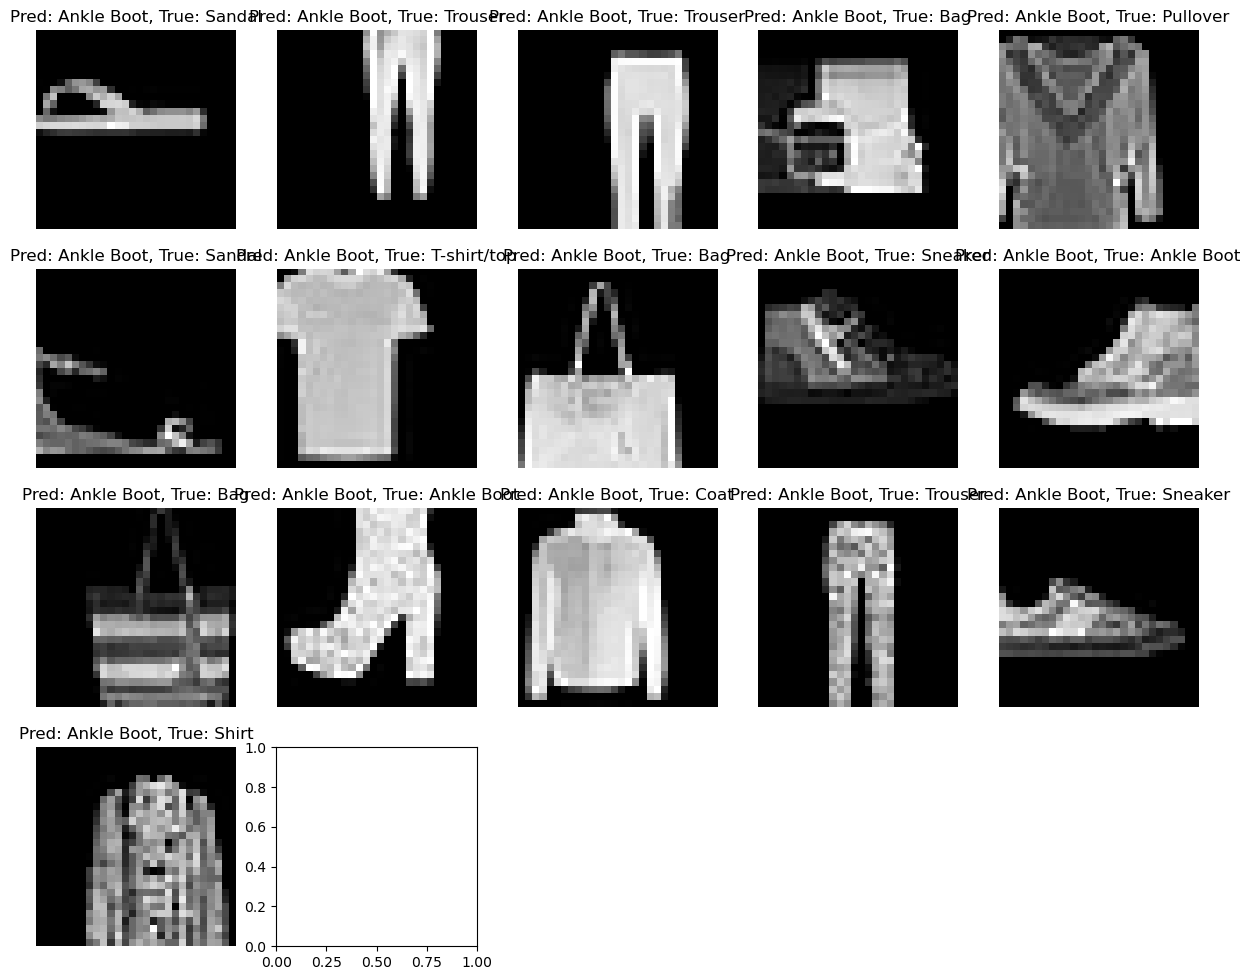

In [22]:
# Define class labels for FashionMNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Visualize 9 images with predictions and true labels
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')  # Unnormalize for grayscale
    plt.title(f"Pred: {classes[predicted[i]]}, True: {classes[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()




---

